<a href="https://colab.research.google.com/github/hiimnhan/scc451/blob/main/scc451.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import math
from scipy.stats import median_abs_deviation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# Task 1: Basel Climate Dataset

In [2]:
basel_df = pd.read_csv('ClimateDataBasel.csv')

In [3]:
# info
basel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_min_c     1763 non-null   float64
 1   temp_max_c     1763 non-null   float64
 2   temp_mean_c    1763 non-null   float64
 3   rh_min_pct     1763 non-null   int64  
 4   rh_max_pct     1763 non-null   int64  
 5   rh_mean_pct    1763 non-null   float64
 6   slp_min_hpa    1763 non-null   float64
 7   slp_max_hpa    1763 non-null   float64
 8   slp_mean_hpa   1763 non-null   float64
 9   precip_mm      1763 non-null   float64
 10  snow_cm        1763 non-null   float64
 11  sunshine_min   1763 non-null   float64
 12  gust_min_kmh   1763 non-null   float64
 13  gust_max_kmh   1763 non-null   float64
 14  gust_mean_kmh  1763 non-null   float64
 15  wind_min_kmh   1763 non-null   float64
 16  wind_max_kmh   1763 non-null   float64
 17  wind_mean_kmh  1763 non-null   float64
dtypes: float

In [4]:
# describe
basel_df.describe()

,temp_min_c,temp_max_c,temp_mean_c,rh_min_pct,rh_max_pct,rh_mean_pct,slp_min_hpa,slp_max_hpa,slp_mean_hpa,precip_mm,snow_cm,sunshine_min,gust_min_kmh,gust_max_kmh,gust_mean_kmh,wind_min_kmh,wind_max_kmh,wind_mean_kmh
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,8.738776,16.779298,12.717350,54.092456,87.004538,71.040509,1014.690925,1020.364492,1017.576393,1.502893,0.068015,399.168240,7.235326,30.464208,17.567084,2.932845,14.858762,8.418839
std,7.803700,9.647769,8.788555,12.949827,7.892077,10.012178,8.848251,8.014133,8.282298,3.496710,0.513935,294.660868,8.221851,16.491422,11.504750,3.470768,7.871249,5.205606
min,-12.519471,-4.389471,-7.628222,19.000000,53.000000,38.333332,976.100000,981.400000,978.450000,0.000000,0.000000,0.000000,0.000000,4.320000,2.715000,0.000000,2.881557,1.495064
25%,1.700529,8.200529,4.689279,44.000000,82.000000,63.520834,1010.300000,1015.900000,1013.233400,0.000000,0.000000,123.972160,2.160000,19.080000,9.765000,0.842431,9.304952,4.872080
50%,10.210529,17.400530,14.618446,54.000000,88.000000,72.000000,1014.600000,1019.500000,1016.954040,0.000000,0.000000,387.746280,4.320000,26.280000,14.145000,1.864800,12.988194,6.939507
75%,15.530529,25.190529,20.432404,64.000000,93.000000,78.750000,1019.300000,1024.400000,1021.760405,1.200000,0.000000,619.156720,8.820000,37.440000,21.667500,3.729600,18.398964,10.108294
max,25.820530,36.700527,30.425112,93.000000,100.000000,95.250000,1043.600000,1049.900000,1047.095800,37.399994,13.860001,962.283300,57.960000,133.200000,90.749990,26.673279,59.192370,36.360706


In [5]:
# Handling missing data
columns = basel_df.columns

missing_summary = pd.DataFrame({
    "Missing Values": basel_df.isna().sum(),
    "Percentage": basel_df.isna().mean() * 100
}).sort_values(by="Missing Values")

missing_summary

,Missing Values,Percentage
temp_min_c,0,0.0
wind_min_kmh,0,0.0
gust_mean_kmh,0,0.0
gust_max_kmh,0,0.0
gust_min_kmh,0,0.0
sunshine_min,0,0.0
snow_cm,0,0.0
precip_mm,0,0.0
slp_mean_hpa,0,0.0
slp_max_hpa,0,0.0


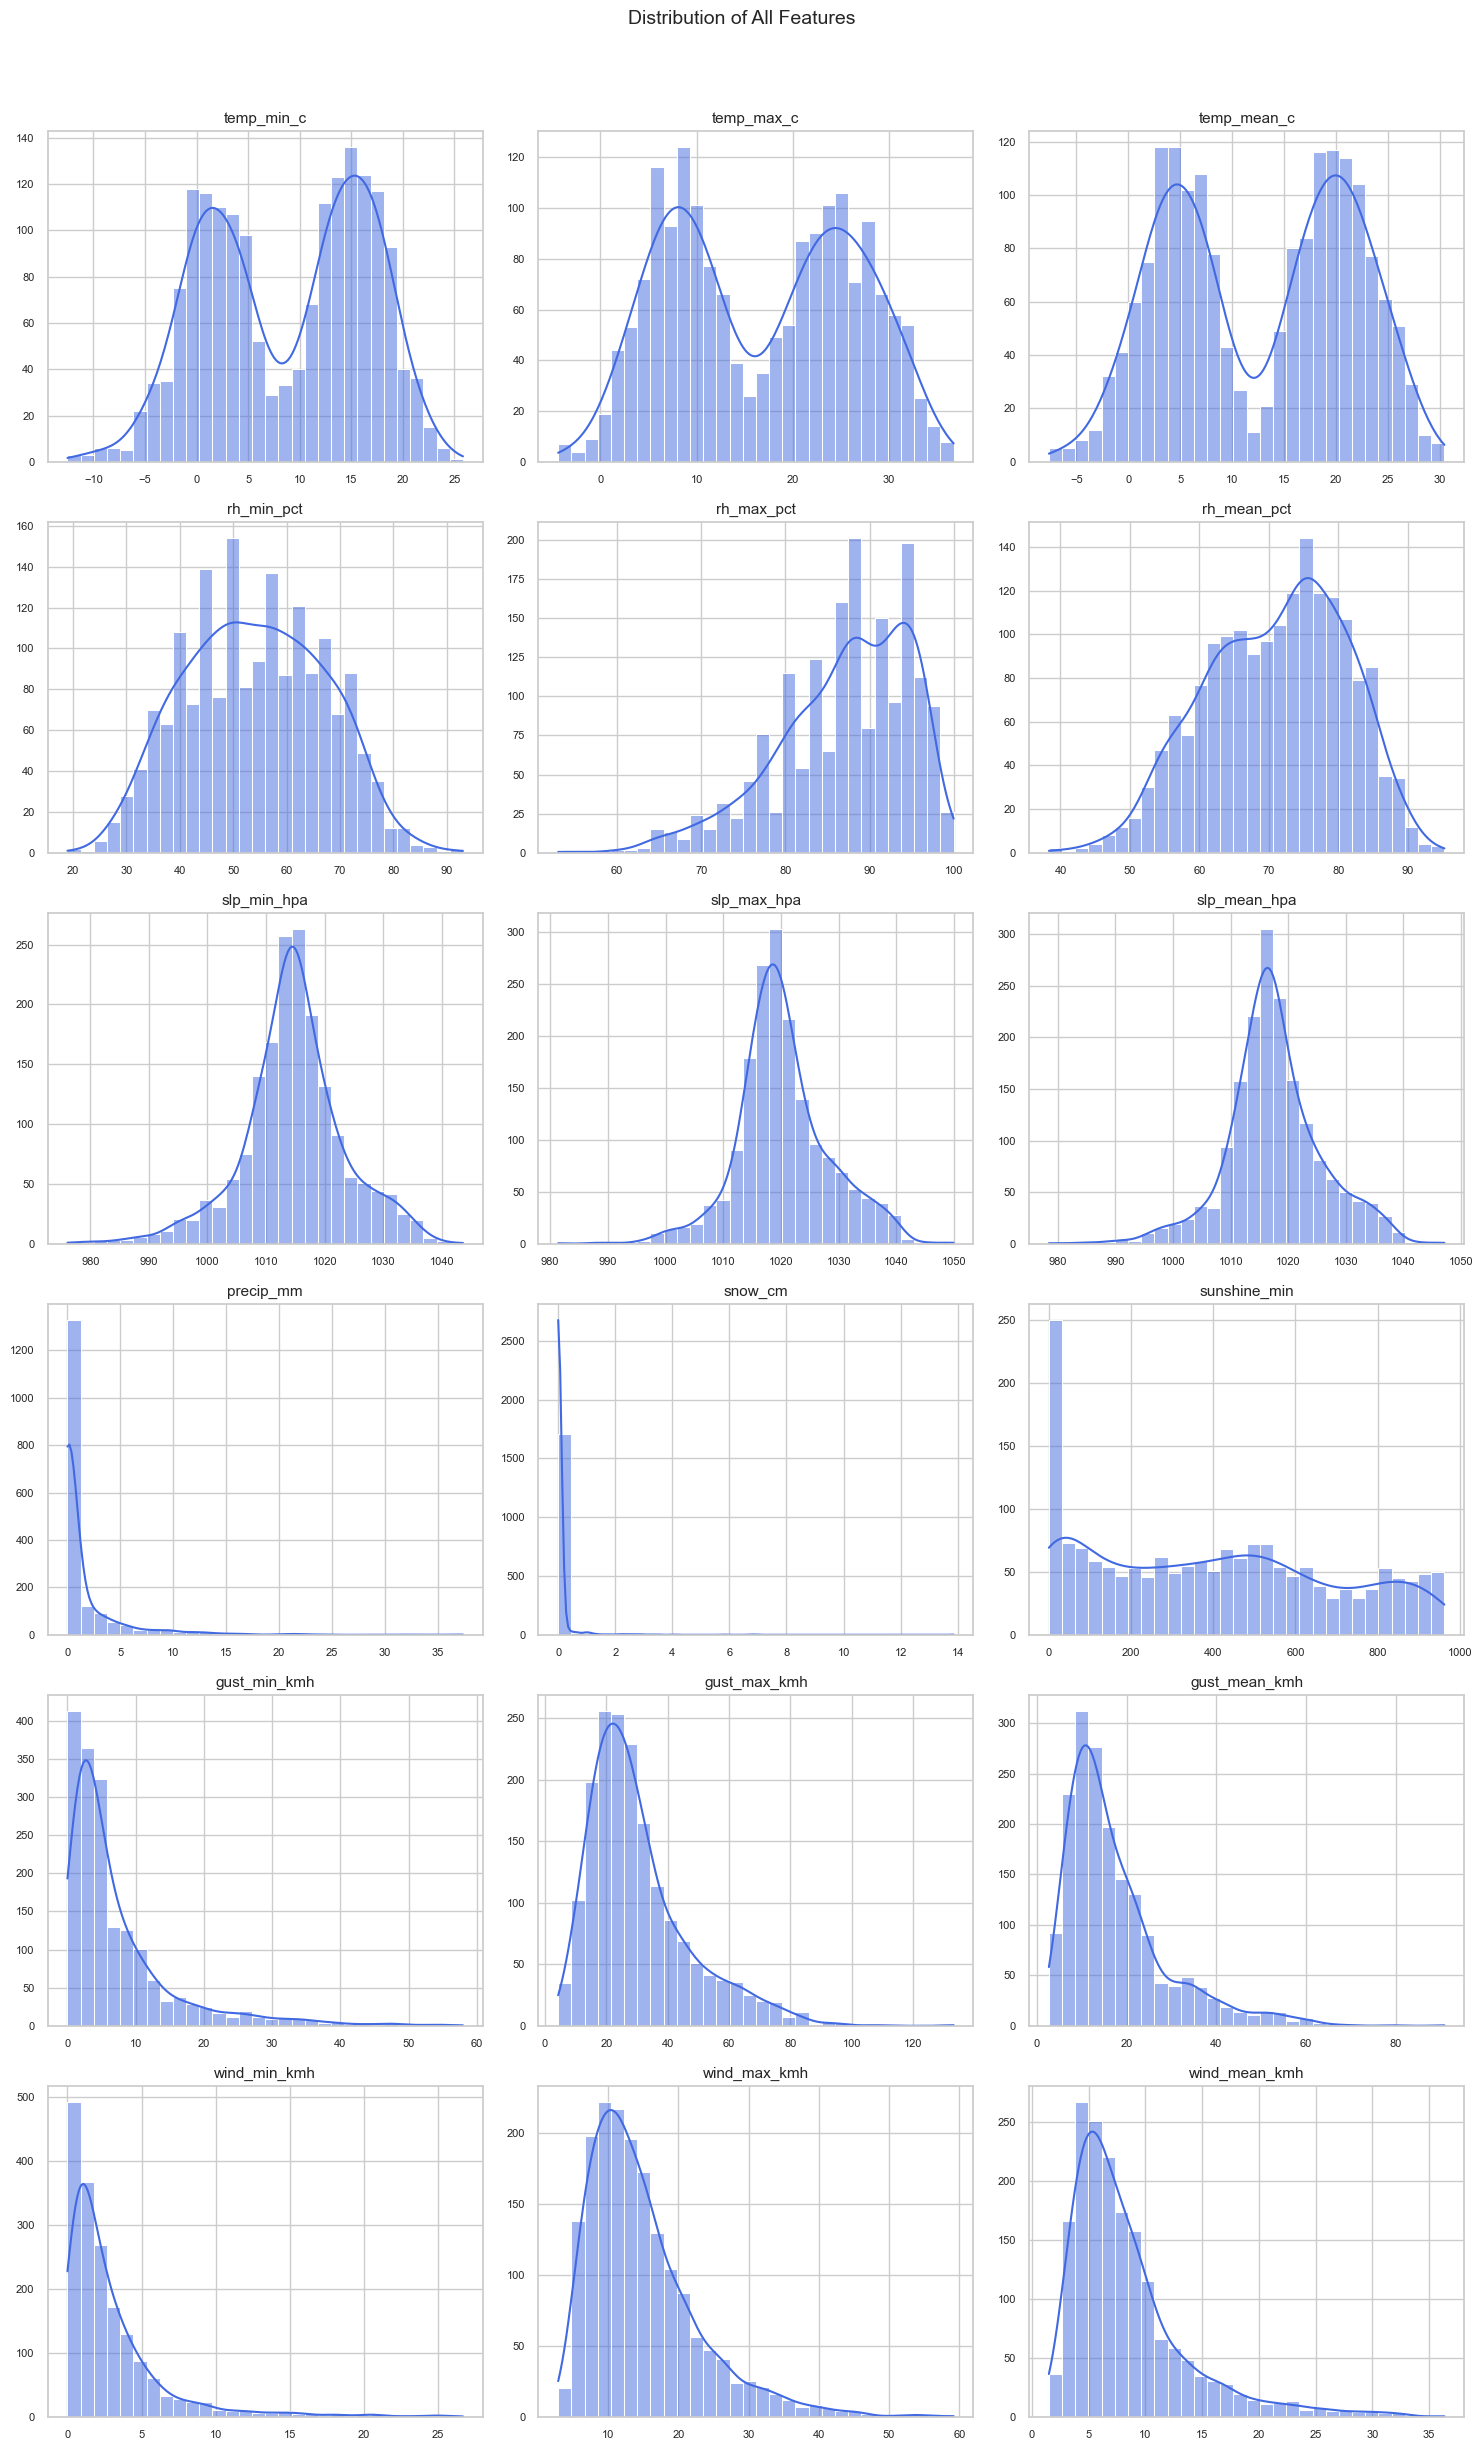

In [6]:
# select only numerical columns
num_cols = basel_df.select_dtypes(include=["number"]).columns

sns.set(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (5, 4),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(basel_df[col], bins=30, kde=True, ax=axes[i], color="royalblue", edgecolor="white")
  axes[i].set_title(col, fontsize=11)
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.suptitle("Distribution of All Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("dist_all_features.png")
plt.show()



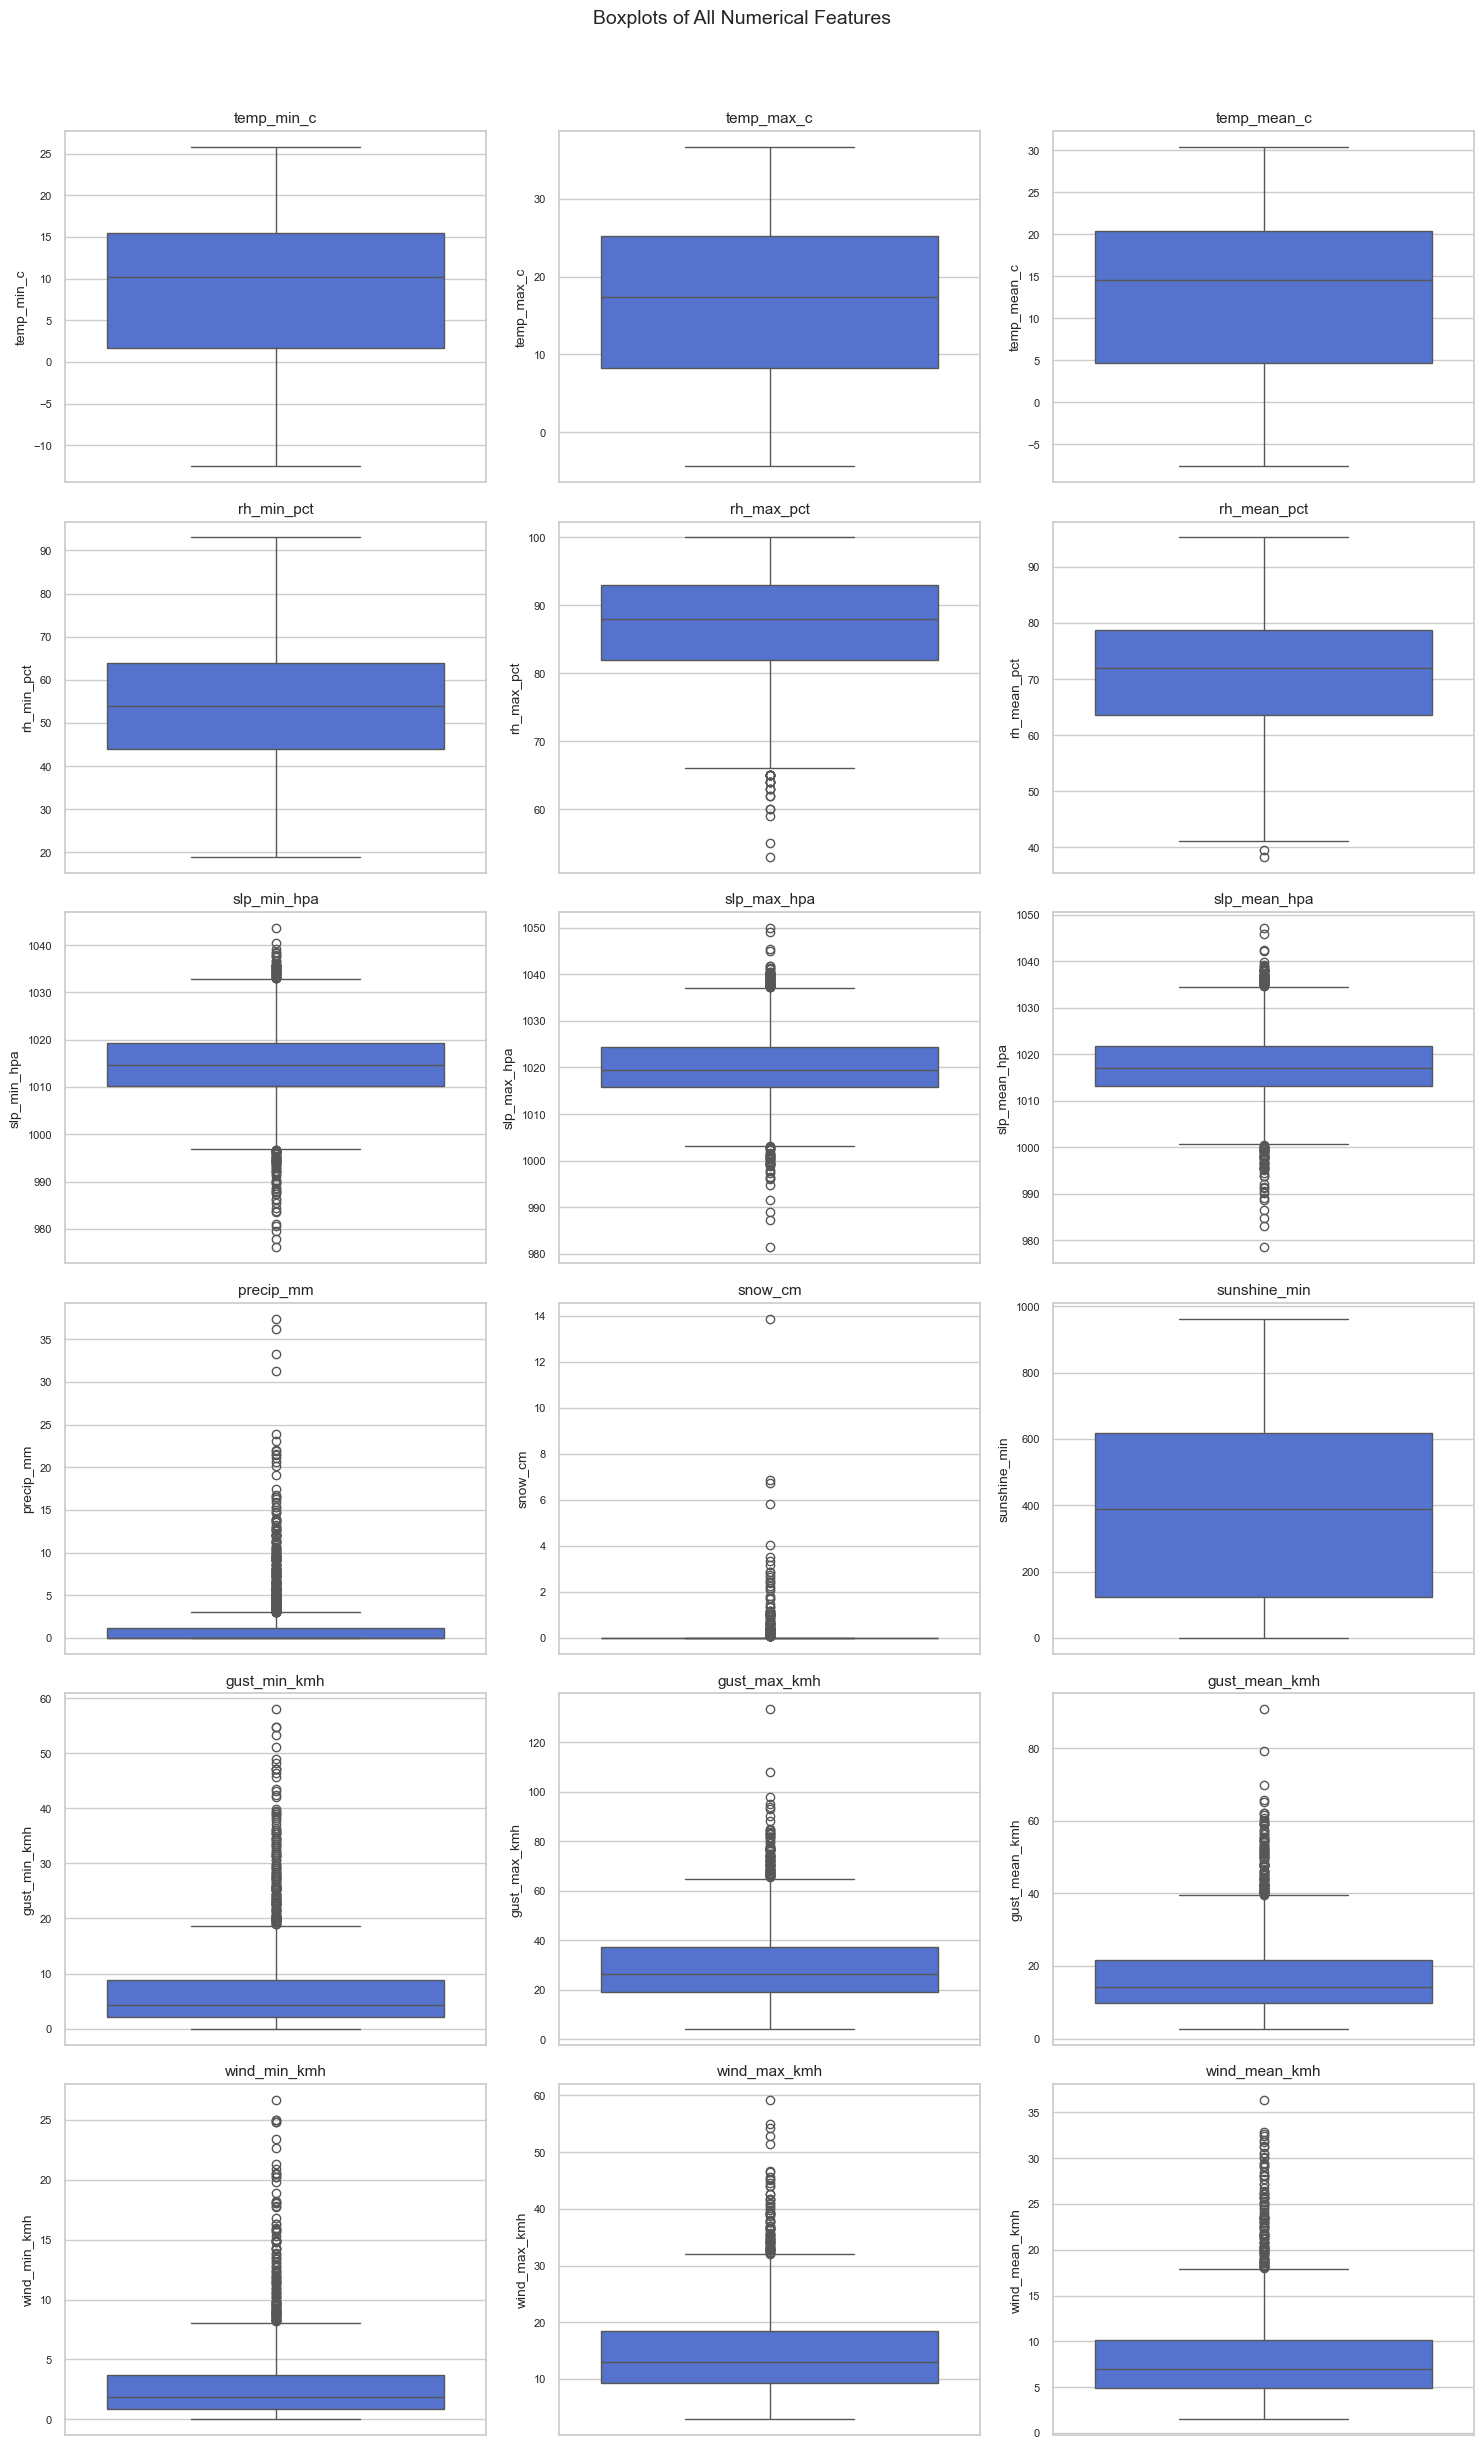

In [7]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(y=basel_df[col], ax=axes[i], color="royalblue")
  axes[i].set_title(col, fontsize=11)
  axes[i].set_xlabel("")

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.suptitle("Boxplots of All Numerical Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("boxplot_features.png")
plt.show()

In [8]:
# Modified Z-score outlier detection
# def modified_zscore(series):
#     median = np.mean(series)
#     mad = median_abs_deviation(series, nan_policy='omit')
#     if mad == 0:
#         return np.zeros_like(series)
#     return 0.6745 * (series - median) / mad

# mad_scores = pd.DataFrame({
#     col: modified_zscore(basel_df[col]) for col in num_cols
# })

# # flag outliers |M| > 3.5
# outlier_flags = (np.abs(mad_scores) > 3.5)

# total_outliers = outlier_flags.sum().sum()
# rows_with_outliers = (outlier_flags.sum(axis=1) > 0).sum()

# print(f"Total flagged values: {total_outliers}")
# print(f"Rows containing outliers {rows_with_outliers} ({rows_with_outliers/len(basel_df)*100:.2f}%)")

In [9]:
# outlier treament
# for col in num_cols:
#     # replace physically invalid:
#     if col.startswith('rh'): #humidity
#         basel_df.loc[basel_df[col] > 100, col] = np.nan
#         basel_df.loc[basel_df[col] < 0, col] = np.nan
#     if "precip" in col or "snow" in col:
#         basel_df.loc[basel_df[col] < 0, col] = np.nan

#     # cap valid extreme
#     low, high = basel_df[col].quantile([0.01, 0.99])
#     basel_df[col] = np.clip(basel_df[col], low, high)

#     # replace high mad score with nan
#     mask = np.abs(mad_scores[col]) > 3.5
#     basel_df.loc[mask, col] = np.nan

# # impute missing values
# imputer = KNNImputer(n_neighbors=5, weights="distance")
# basel_df[num_cols] = imputer.fit_transform(basel_df[num_cols])

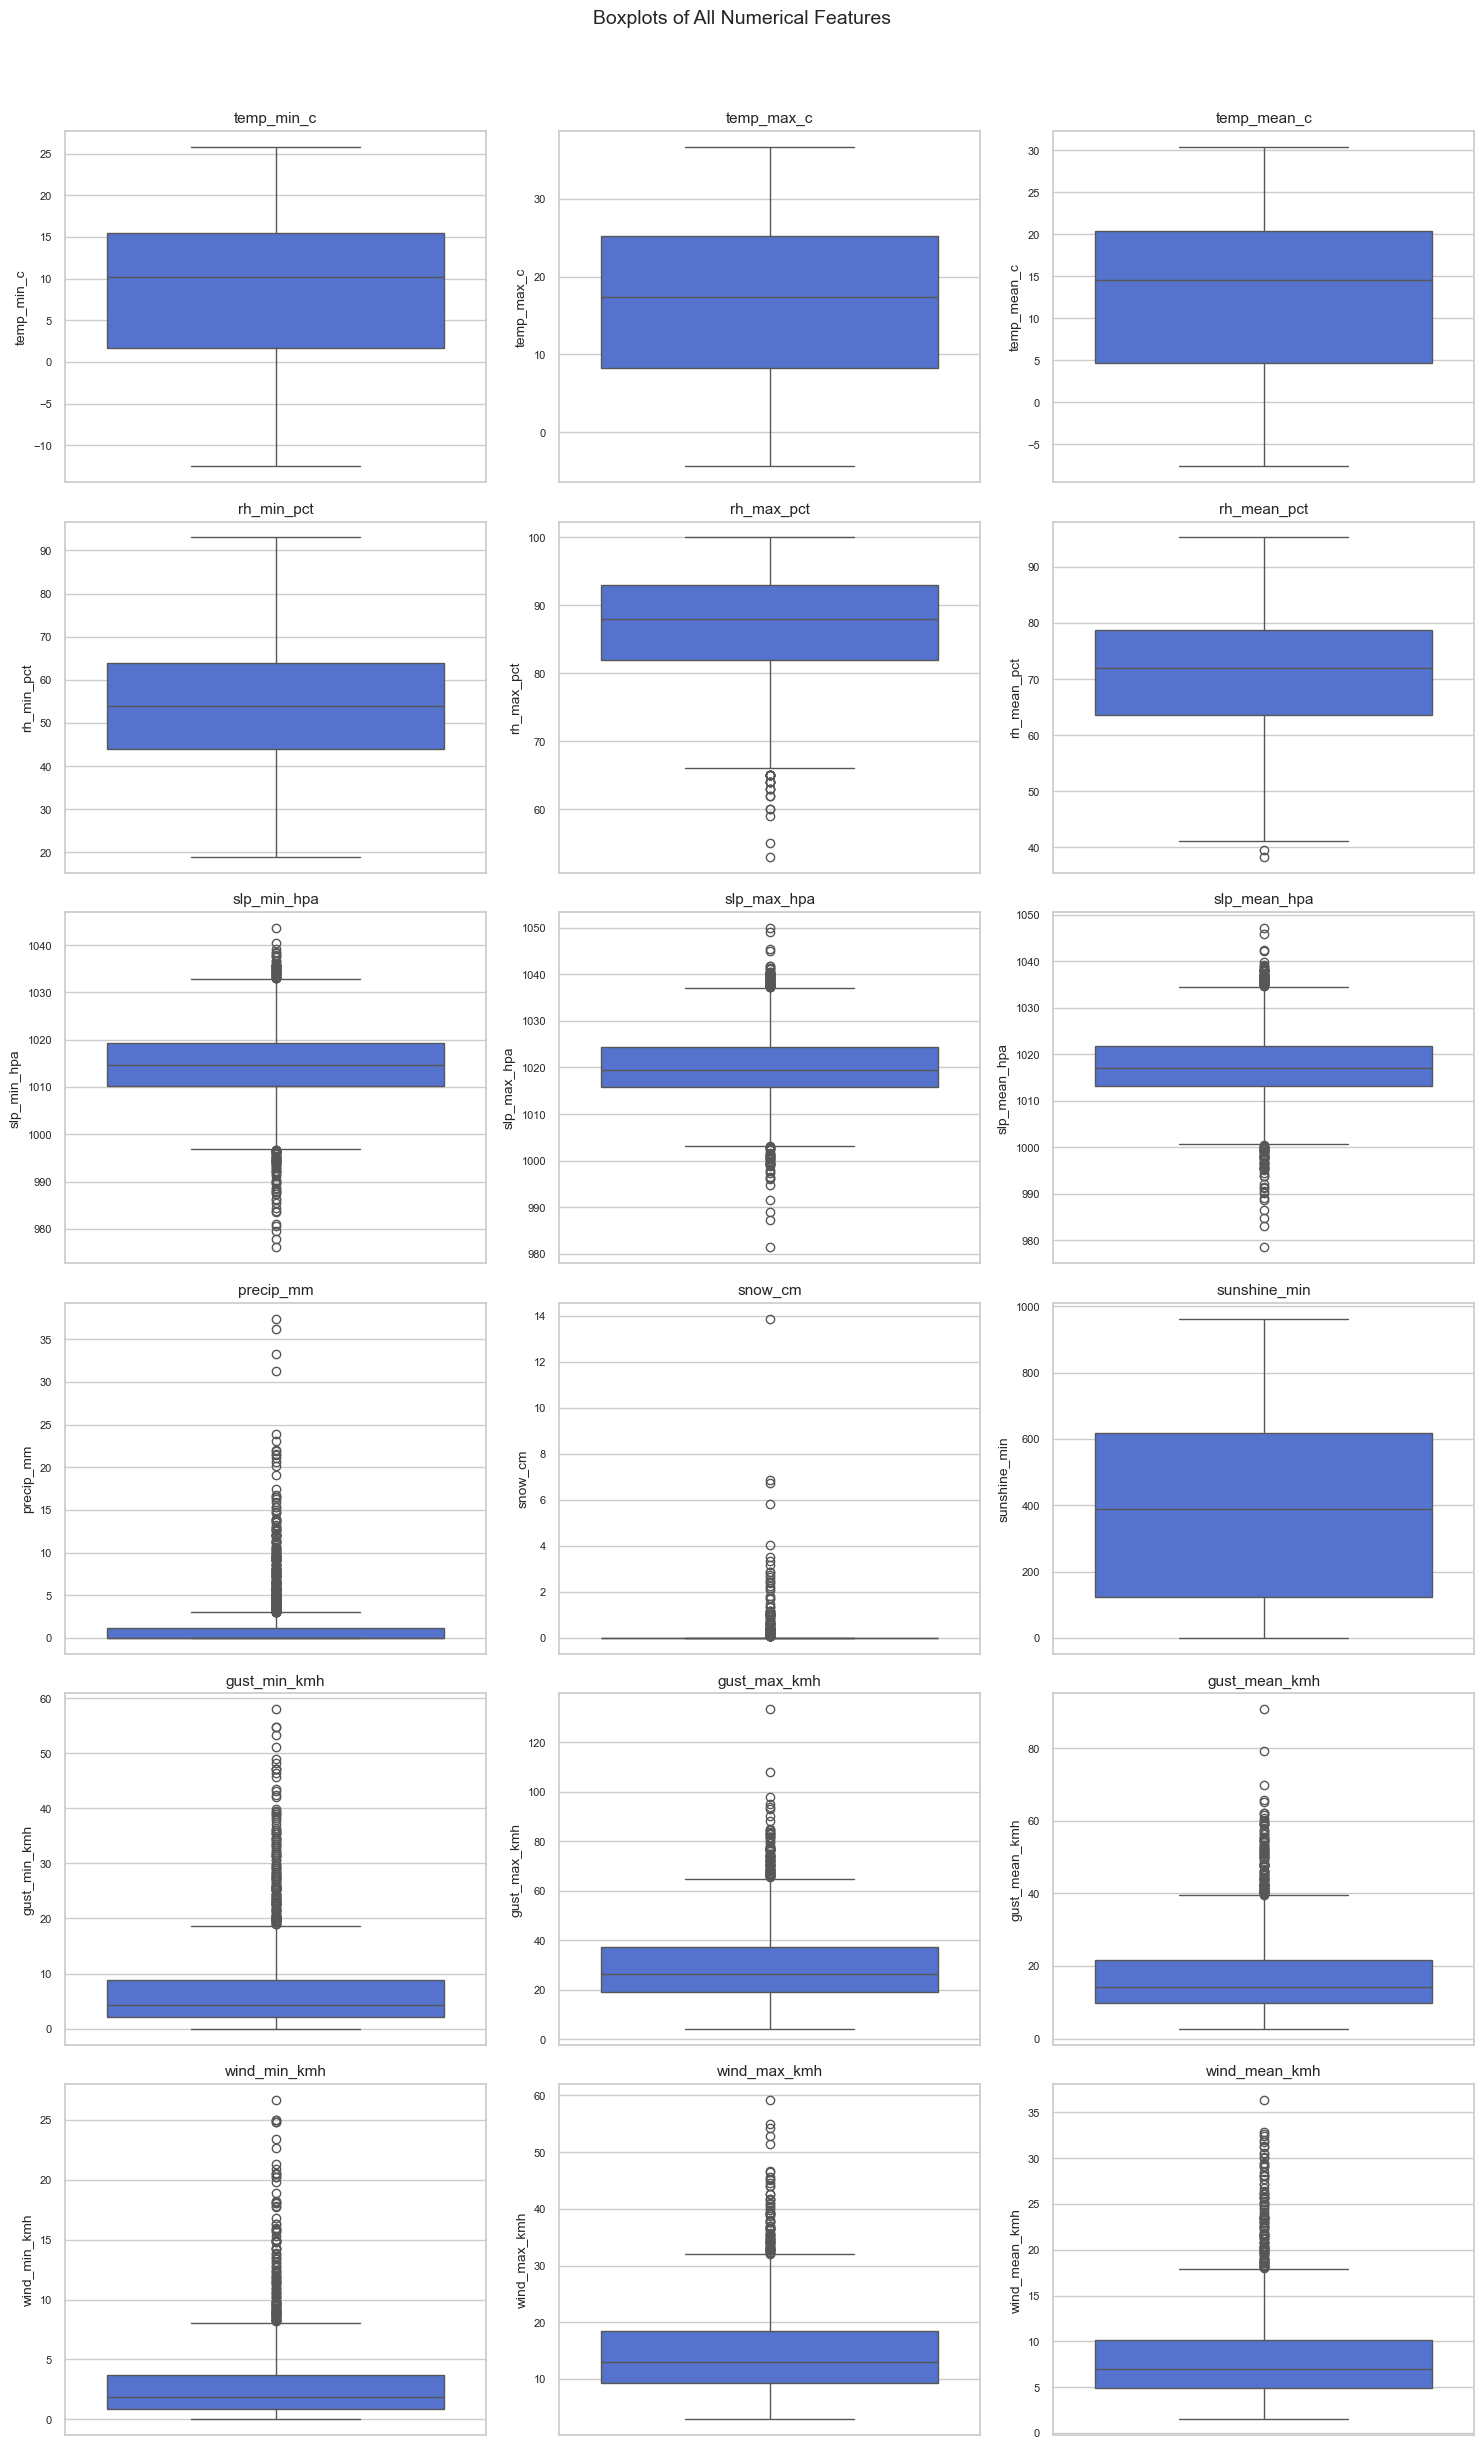

In [10]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(y=basel_df[col], ax=axes[i], color="royalblue")
  axes[i].set_title(col, fontsize=11)
  axes[i].set_xlabel("")

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.suptitle("Boxplots of All Numerical Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [11]:
scaler = RobustScaler()
basel_df_scaled = pd.DataFrame(
    scaler.fit_transform(basel_df[num_cols]),
    columns=num_cols,
    index=basel_df.index
)

In [25]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
labels = lof.fit_predict(basel_df_scaled)
scores = -lof.negative_outlier_factor_

basel_df['lof_label'] = labels
basel_df['lof_score'] = scores

n_outliers = (labels == -1).sum()
print(f"Detected {n_outliers} outliers ({n_outliers/len(basel_df)*100:.2f}%)")

Detected 13 outliers (0.74%)


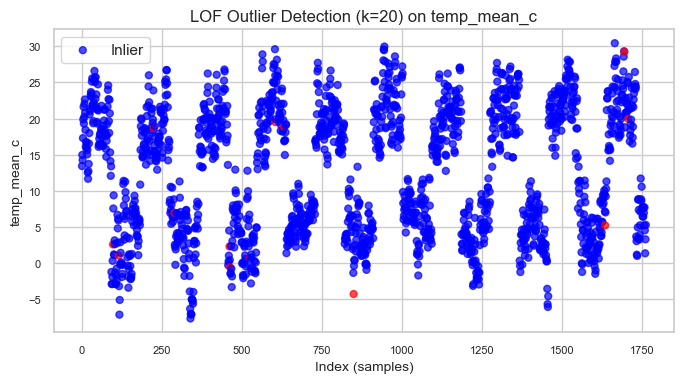

In [26]:
feature = 'temp_mean_c'
plt.figure(figsize=(7,4))
plt.scatter(basel_df.index, basel_df[feature],
            c=np.where(basel_df["lof_label"] == -1, "red", "blue"),
            s=25, alpha=0.7)
plt.title(f"LOF Outlier Detection (k=20) on {feature}")
plt.xlabel("Index (samples)")
plt.ylabel(feature)
plt.legend(["Inlier", "Outlier"], loc="best")
plt.tight_layout()
plt.show()

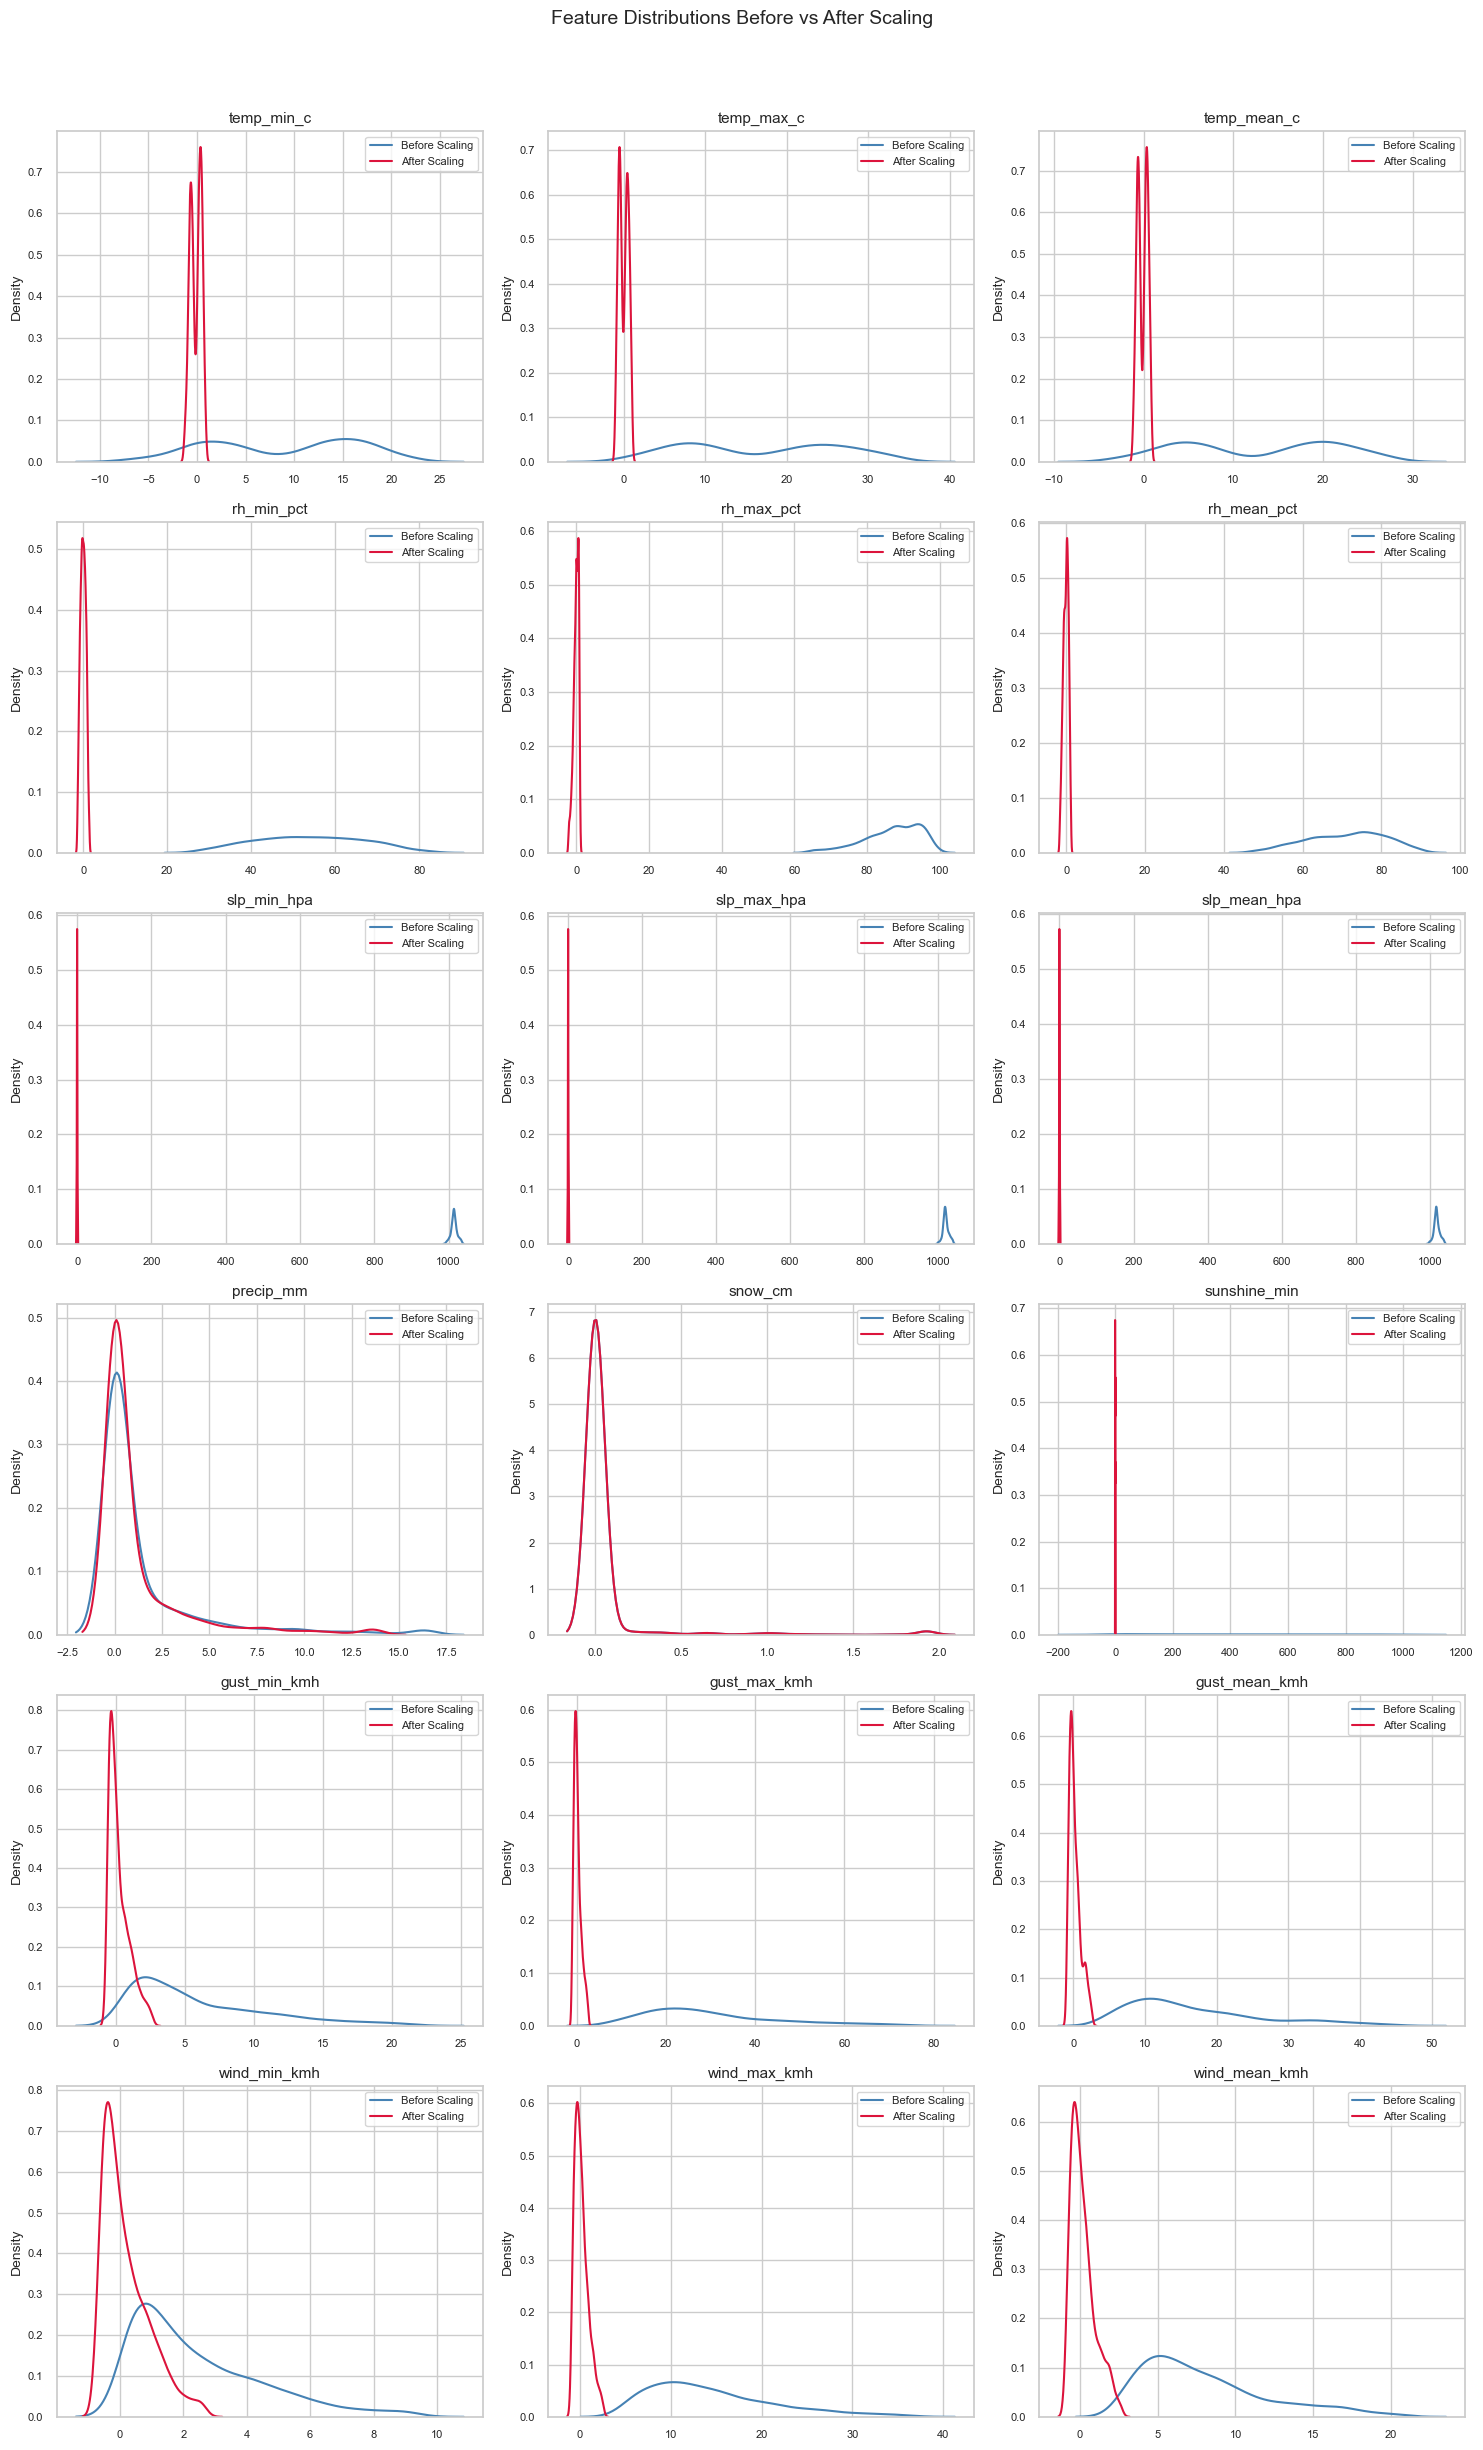

In [ ]:
# compare distributions before and after scaling
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(basel_df[col], ax=axes[i], label="Before Scaling", color="steelblue")
    sns.kdeplot(basel_df_scaled[col], ax=axes[i], label="After Scaling", color="crimson")
    axes[i].set_title(col, fontsize=11)
    axes[i].legend(fontsize=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions Before vs After Scaling", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("feature_scaling.png")
plt.show()

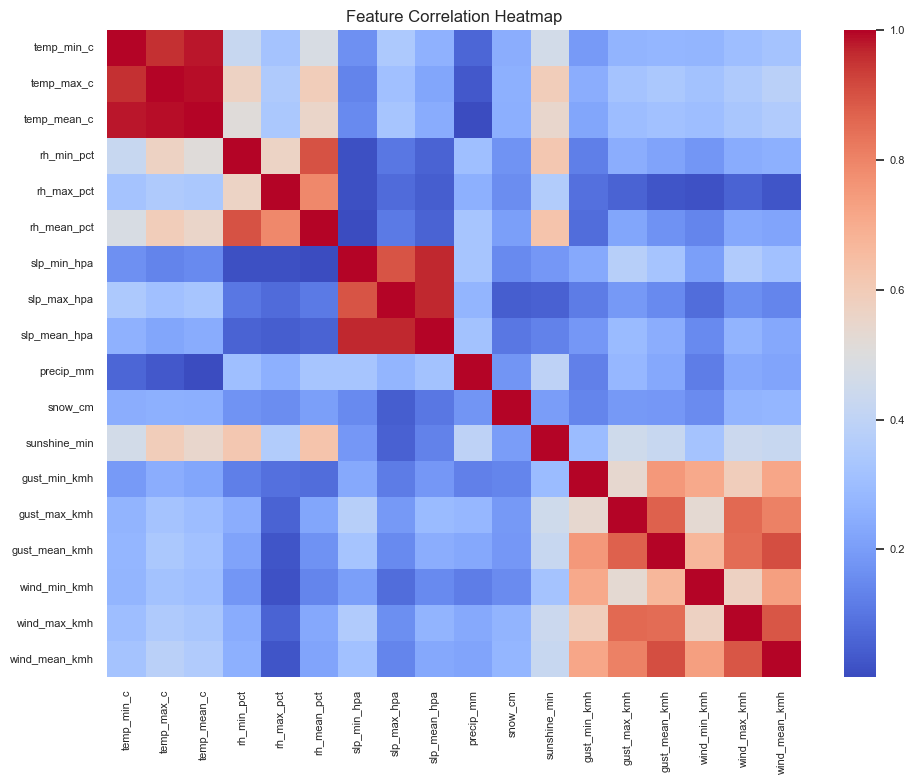

In [ ]:
# Analyse feature correlation
corr = basel_df_scaled.corr().abs()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# keep only upper triangle because correlation matrix is symmetric
# that every pair is shown twice, it might be a problem because it
# can lead to accidentially remove both features.
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] >= 0.95)]
print("Highly correlated columns to drop:", high_corr)

Highly correlated columns to drop: ['temp_max_c', 'temp_mean_c', 'slp_mean_hpa']


In [ ]:
df_reduced = basel_df
df_reduced["temp_range"] = basel_df["temp_max_c"] - basel_df["temp_min_c"]
df_reduced["rh_range"]   = basel_df["rh_max_pct"] - basel_df["rh_min_pct"]
df_reduced["slp_range"]  = basel_df["slp_max_hpa"] - basel_df["slp_min_hpa"]
df_reduced["wind_range"] = basel_df["wind_max_kmh"] - basel_df["wind_min_kmh"]
df_reduced["gust_range"] = basel_df["gust_max_kmh"] - basel_df["gust_min_kmh"]

# Drop min/max columns after creating range features
drop_cols = [
    "temp_min_c","temp_max_c",
    "rh_min_pct","rh_max_pct",
    "slp_min_hpa","slp_max_hpa",
    "wind_min_kmh","wind_max_kmh",
    "gust_min_kmh","gust_max_kmh"
]
df_reduced = df_reduced.drop(columns=[c for c in drop_cols if c in df_reduced.columns])
df_reduced.columns

Index(['temp_mean_c', 'rh_mean_pct', 'slp_mean_hpa', 'precip_mm', 'snow_cm',
       'sunshine_min', 'gust_mean_kmh', 'wind_mean_kmh', 'temp_range',
       'rh_range', 'slp_range', 'wind_range', 'gust_range'],
      dtype='object')

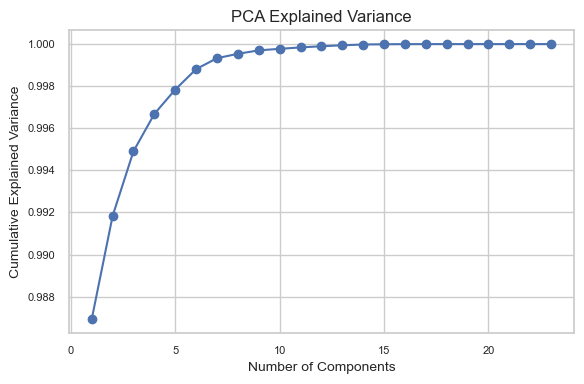

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(basel_df)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pca_final = PCA(n_components=3)
X_pca = pca_final.fit_transform(df_reduced)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
print("Explained variance ( PCs):", pca_final.explained_variance_ratio_.sum())
pca_df

Explained variance ( PCs): 0.9976127216058309


,PC1,PC2,PC3
0,-48.416135,-7.731337,1.063839
1,-111.701066,-7.613070,4.136895
2,-272.825525,-12.700104,-1.926735
3,482.059895,1.912561,-10.544592
4,551.834648,-1.692318,-4.372735
...,...,...,...
1758,-399.604556,-10.137872,-16.568831
1759,103.708214,-4.148658,-9.404033
1760,90.738439,-5.767336,-3.559688
1761,114.131488,-1.842185,-7.671902
